In [80]:
! pip install pyspark py4j

In [81]:
import datetime as dt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import *

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Convert Excel format to CSV format.

In [83]:
#excel_path = '/Users/shalu/Downloads/forecasting_case_study.xlsx - Sheet1.csv'
#csv_output_path = '/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv'

df = pd.read_csv('/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv')

#df.to_csv(csv_output_path, index=False)

In [84]:
from pyspark.sql import SparkSession

In [85]:
spark = SparkSession.builder.appName("ReadDataExample").getOrCreate()

Read csv.

In [86]:
csv_file_path = "/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [87]:
df.show(5)

+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1|2017-02-05|27750|               0.0|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-12|29023|               0.0|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2017-02-19|45630|              0.17|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-26|26789|               0.0|             1|              0|              1|            0.0|         0|    0|     0|        0|

In [88]:
display( df )

DataFrame[Product: string, date: date, Sales: int, Price Discount (%): double, In-Store Promo: int, Catalogue Promo: int, Store End Promo: int, Google_Mobility: double, Covid_Flag: int, V_DAY: int, EASTER: int, CHRISTMAS: int]

Check if there are missing values.

In [89]:
from pyspark.sql.functions import col, isnan, when, count

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns if df.schema[c].dataType != 'date'])
missing_counts.show()

+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      0|   0|    0|                 0|             0|              0|              0|              0|         0|    0|     0|        0|
+-------+----+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+



**Observation**  
No missng values existing

In [90]:
df.count(), len(df.columns)

(1218, 12)

**Observation**  
1218 observations and 12 columns.

In [91]:
df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- date: date (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Price Discount (%): double (nullable = true)
 |-- In-Store Promo: integer (nullable = true)
 |-- Catalogue Promo: integer (nullable = true)
 |-- Store End Promo: integer (nullable = true)
 |-- Google_Mobility: double (nullable = true)
 |-- Covid_Flag: integer (nullable = true)
 |-- V_DAY: integer (nullable = true)
 |-- EASTER: integer (nullable = true)
 |-- CHRISTMAS: integer (nullable = true)



**Observation**   
PySpark does not support "categorical" data type. So, we don't convert the data type for "In-Store Promo", "Catalogue Promo", "Store End Promo", "Covid_Flag", "V_DAY", "EASTER", and "CHRISTMAS".  In general, PySpark uses "string" and "integer" for "categorical" values.  

In [92]:
df.select("Sales", "Google_Mobility")

DataFrame[Sales: int, Google_Mobility: double]

Validate the name of columns. Put _ between word in stead of space.

In [93]:
df = (
    df
    .withColumnRenamed("Price Discount (%)", "Price_Discount_(%)")
    .withColumnRenamed("In-Store Promo", "In-Store_Promo")
    .withColumnRenamed("Catalogue Promo", "Catalogue_Promo")
    .withColumnRenamed("Store End Promo", "Store_End_Promo")
)

In [94]:
df.show(5)

+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|Product|      date|Sales|Price_Discount_(%)|In-Store_Promo|Catalogue_Promo|Store_End_Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+-------+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|   SKU1|2017-02-05|27750|               0.0|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-12|29023|               0.0|             1|              0|              1|            0.0|         0|    1|     0|        0|
|   SKU1|2017-02-19|45630|              0.17|             0|              0|              0|            0.0|         0|    0|     0|        0|
|   SKU1|2017-02-26|26789|               0.0|             1|              0|              1|            0.0|         0|    0|     0|        0|

In [95]:
duplicates = df.groupBy("Product").count().filter(col("count") > 1)
duplicates.show()

+-------+-----+
|Product|count|
+-------+-----+
|   SKU3|  204|
|   SKU4|  204|
|   SKU1|  204|
|   SKU5|  204|
|   SKU6|  198|
|   SKU2|  204|
+-------+-----+



**Observation**  
6products

In [96]:
description = df.describe()
description.show()

+-------+-------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|summary|Product|             Sales| Price_Discount_(%)|    In-Store_Promo|    Catalogue_Promo|    Store_End_Promo|    Google_Mobility|         Covid_Flag|               V_DAY|              EASTER|           CHRISTMAS|
+-------+-------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|  count|   1218|              1218|               1218|              1218|               1218|               1218|               1218|               1218|                1218|                1218|                1218|
|   mean|   null|30294.678981937603| 0.2510426929392443|0.4720853858784893|0.21264367816091953|0.34893267651888343|-2.377405

In [97]:
df.describe().toPandas()

,summary,Product,Sales,Price_Discount_(%),In-Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,count,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218
1,mean,None,30294.678981937603,0.2510426929392443,0.4720853858784893,0.21264367816091953,0.34893267651888343,-2.3774055829228224,0.22660098522167488,0.019704433497536946,0.019704433497536946,0.018883415435139574
2,stddev,None,35032.5272965258,0.21549350172360285,0.4994252268419534,0.40934571855807333,0.47682841234861867,5.806290981009834,0.4188042296935616,0.13903970926580328,0.13903970926580325,0.13616921612117958
3,min,SKU1,0,0.0,0,0,0,-28.49,0,0,0,0
4,max,SKU6,288322,0.83,1,1,1,3.9,1,1,1,1


PySpark is not good at Visualization. So, we convert it to pandas format to plot graphs.

In [98]:
pandas_df = df.toPandas()

In [99]:
pandas_df.describe(include= ['object']).T

,count,unique,top,freq
Product,1218,6,SKU1,204
date,1218,204,2017-02-05,6


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()

In [101]:
df.head()

Row(Product='SKU1', date=datetime.date(2017, 2, 5), Sales=27750, Price_Discount_(%)=0.0, In-Store_Promo=0, Catalogue_Promo=0, Store_End_Promo=0, Google_Mobility=0.0, Covid_Flag=0, V_DAY=0, EASTER=0, CHRISTMAS=0)

<Axes: xlabel='date', ylabel='Sales'>

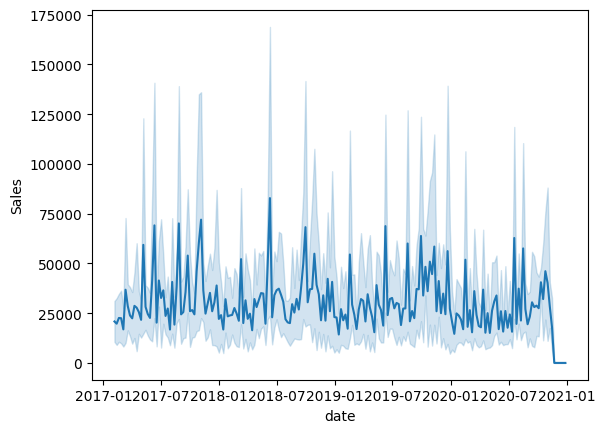

In [102]:
sns.lineplot(x = 'date', y = 'Sales', data=pandas_df)

In [103]:
df=spark.read.option("header",True) \
        .csv("/content/drive/MyDrive/Data_Glacier/Week7/forecasting_case_study.csv")

In [104]:
df.write.option("header", True) \
        .partitionBy("Product") \
        .mode("overwrite") \
        .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast")

In [105]:
dfSinglePart=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU1")

In [106]:
dfSinglePart2=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU2")

In [107]:
dfSinglePart3=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU3")

In [108]:
dfSinglePart4=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU4")

In [109]:
dfSinglePart5=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU5")

In [110]:
dfSinglePart6=spark.read.option("header",True) \
            .csv("/content/drive/MyDrive/Colab Notebooks/DG/Forecast/Product=SKU6")

In [111]:
def histplot_boxplot(feature, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined

    feature: 1-d feature array

    figsize: size of fig (default (9, 8))

    bins: number of bins (default None / auto)

    """
    f2, (ax_box2, ax_his2) = plt.subplots(nrows=2,  # Number of rows of the subplot grid = 2
                                           sharex=True,  # X-axis will be shared among all subplots
                                           gridspec_kw={"height_ratios": (.25, .75)},
                                           figsize=figsize
                                           )  # Creating the 2 subplots

    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet')  # Boxplot will be created and a symbol will indicate the mean value of the column

    if bins:
        sns.histplot(x=feature, kde=True, ax=ax_his2, bins=bins, palette="winter")  # For histogram
    else:
        sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram

    ax_his2.axvline(np.mean(feature), color='green', linestyle='--')  # Add mean to the histogram

    ax_his2.axvline(np.median(feature), color='black', linestyle='-')  # Add median to the histogram


In [112]:
dfSinglePart.printSchema()
dfSinglePart.show()
df1= dfSinglePart.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date| Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 27750|               0.0|             0|              0|              0|            0.0|         0|    0|

In [113]:
dfSinglePart2.printSchema()
dfSinglePart2.show()
df2= dfSinglePart2.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 7180|              0.25|             1|              0|              0|            0.0|         0|    0|    

In [114]:
dfSinglePart3.printSchema()
dfSinglePart3.show()
df3= dfSinglePart3.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date| Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 39767|               0.3|             0|              1|              1|            0.0|         0|    0|

In [115]:
dfSinglePart4.printSchema()
dfSinglePart4.show()
df4= dfSinglePart4.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05|12835|               0.3|             0|              1|              1|            0.0|         0|    0|    

In [116]:
dfSinglePart5.printSchema()
dfSinglePart5.show()
df5= dfSinglePart5.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date|Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+-----+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 5229|               0.0|             0|              0|              0|            0.0|         0|    0|    

In [117]:
dfSinglePart6.printSchema()
dfSinglePart6.show()
df6= dfSinglePart6.toPandas()

root
 |-- date: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Price Discount (%): string (nullable = true)
 |-- In-Store Promo: string (nullable = true)
 |-- Catalogue Promo: string (nullable = true)
 |-- Store End Promo: string (nullable = true)
 |-- Google_Mobility: string (nullable = true)
 |-- Covid_Flag: string (nullable = true)
 |-- V_DAY: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)

+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|      date| Sales|Price Discount (%)|In-Store Promo|Catalogue Promo|Store End Promo|Google_Mobility|Covid_Flag|V_DAY|EASTER|CHRISTMAS|
+----------+------+------------------+--------------+---------------+---------------+---------------+----------+-----+------+---------+
|2017-02-05| 32138|              0.28|             0|              0|              0|            0.0|         0|    0|

In [118]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df1['Price Discount (%)'] = df1['Price Discount (%)'].apply(convert_to_int)

In [119]:
#df1['Price Discount (%)']= df1['Price Discount (%)'].str[:-1]
#df1['Price Discount (%)']= df1['Price Discount (%)'].astype(int)

In [120]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df2['Price Discount (%)'] = df2['Price Discount (%)'].apply(convert_to_int)

In [121]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df3['Price Discount (%)'] = df3['Price Discount (%)'].apply(convert_to_int)

In [122]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df4['Price Discount (%)'] = df4['Price Discount (%)'].apply(convert_to_int)

In [123]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df5['Price Discount (%)'] = df5['Price Discount (%)'].apply(convert_to_int)

In [124]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return np.nan
df6['Price Discount (%)'] = df6['Price Discount (%)'].apply(convert_to_int)

In [125]:
df1.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [126]:
df2.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [141]:
df3.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [142]:
df4.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [143]:
df5.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [144]:
df6.dtypes

date                  object
Sales                 object
Price Discount (%)     int64
In-Store Promo        object
Catalogue Promo       object
Store End Promo       object
Google_Mobility       object
Covid_Flag            object
V_DAY                 object
EASTER                object
CHRISTMAS             object
dtype: object

In [146]:

cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df1[cols]=df1[cols].apply(pd.to_numeric)
df1['date']=df1['date'].apply(pd.to_datetime)
#df1=df1[df1['Sales'] !=0]

In [145]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df2[cols]=df2[cols].apply(pd.to_numeric)
df2['date']=df2['date'].apply(pd.to_datetime)

In [147]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df3[cols]=df3[cols].apply(pd.to_numeric)
df3['date']=df3['date'].apply(pd.to_datetime)

In [148]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df4[cols]=df4[cols].apply(pd.to_numeric)
df4['date']=df4['date'].apply(pd.to_datetime)

In [149]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df5[cols]=df5[cols].apply(pd.to_numeric)
df5['date']=df5['date'].apply(pd.to_datetime)

In [150]:
cols=['Sales','Price Discount (%)','In-Store Promo','Catalogue Promo','Store End Promo','Google_Mobility','Covid_Flag','V_DAY','EASTER','CHRISTMAS']
df6[cols]=df6[cols].apply(pd.to_numeric)
df6['date']=df6['date'].apply(pd.to_datetime)

In [151]:
df1.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,1,0,1,-5.30,1,0,0,0
200,2020-12-06,0,0,1,0,1,-4.38,1,0,0,0
201,2020-12-13,0,0,1,0,1,-4.74,1,0,0,0
202,2020-12-20,0,0,1,0,1,-10.27,1,0,0,1
203,2020-12-27,0,0,1,0,0,-6.95,1,0,0,0


In [152]:
df2.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,1,0,0,-5.30,1,0,0,0
200,2020-12-06,0,0,0,0,0,-4.38,1,0,0,0
201,2020-12-13,0,0,0,0,0,-4.74,1,0,0,0
202,2020-12-20,0,0,0,0,0,-10.27,1,0,0,1
203,2020-12-27,0,0,0,0,0,-6.95,1,0,0,0


In [153]:
df3.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,0,1,0,-5.30,1,0,0,0
200,2020-12-06,0,0,1,0,0,-4.38,1,0,0,0
201,2020-12-13,0,0,0,1,0,-4.74,1,0,0,0
202,2020-12-20,0,0,0,1,0,-10.27,1,0,0,1
203,2020-12-27,0,0,1,0,1,-6.95,1,0,0,0


In [154]:
df4.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,0,1,0,-5.30,1,0,0,0
200,2020-12-06,0,0,1,0,0,-4.38,1,0,0,0
201,2020-12-13,0,0,0,1,0,-4.74,1,0,0,0
202,2020-12-20,0,0,0,1,0,-10.27,1,0,0,1
203,2020-12-27,0,0,1,0,1,-6.95,1,0,0,0


In [156]:
df5.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
199,2020-11-29,0,0,0,0,0,-5.30,1,0,0,0
200,2020-12-06,0,0,1,0,0,-4.38,1,0,0,0
201,2020-12-13,0,0,1,0,0,-4.74,1,0,0,0
202,2020-12-20,0,0,1,0,0,-10.27,1,0,0,1
203,2020-12-27,0,0,0,0,0,-6.95,1,0,0,0


In [157]:
df6.tail()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
193,2020-10-18,96619,0,0,1,0,-7.56,1,0,0,0
194,2020-10-25,115798,0,0,1,0,-8.39,1,0,0,0
195,2020-11-01,152186,0,1,0,1,-7.43,1,0,0,0
196,2020-11-08,26445,0,1,0,1,-5.95,1,0,0,0
197,2020-11-15,26414,0,0,0,0,-7.20,1,0,0,0


<ipython-input-111-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


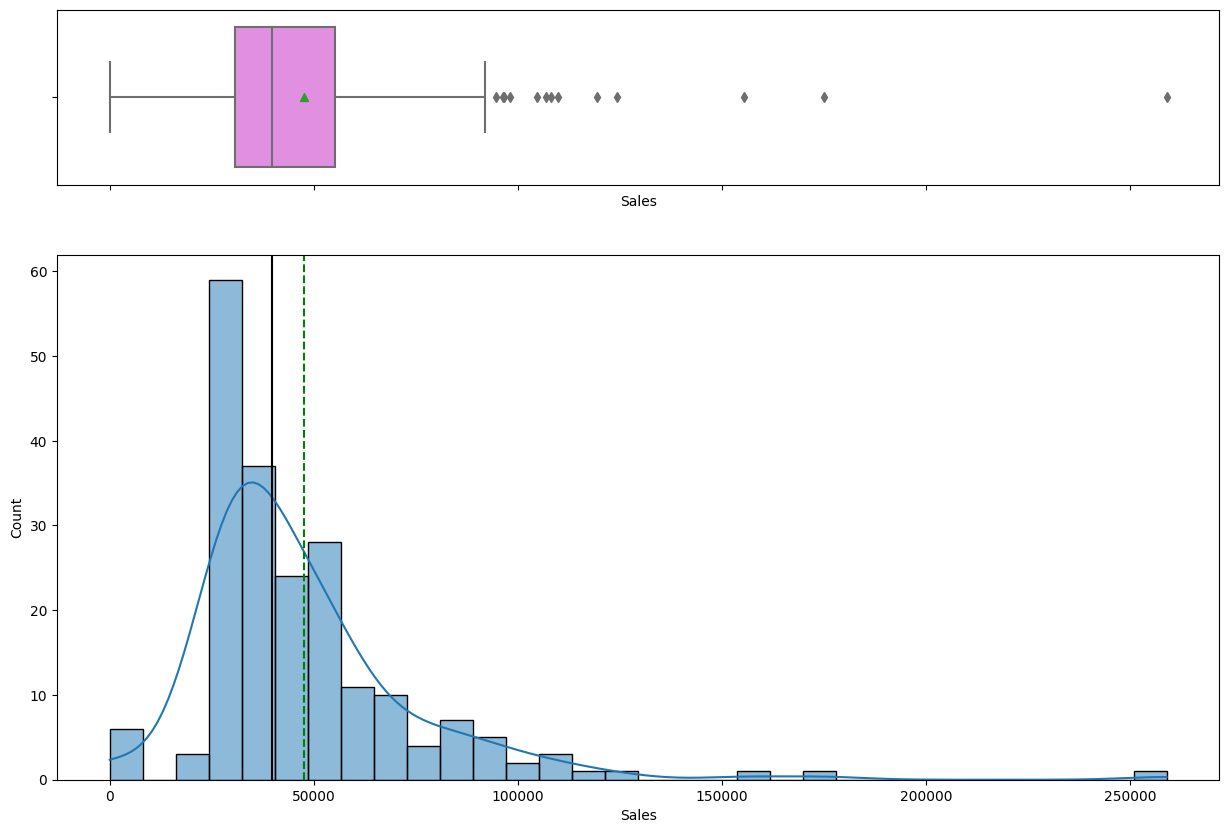

In [129]:
histplot_boxplot(df1['Sales'])

In [130]:
df1.describe()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,204.000000,204.0,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,47521.901961,0.0,0.421569,0.088235,0.259804,-2.396471,0.230392,0.019608,0.019608,0.019608
std,29187.725878,0.0,0.495025,0.284335,0.439606,5.811945,0.422120,0.138989,0.138989,0.138989
min,0.000000,0.0,0.000000,0.000000,0.000000,-28.490000,0.000000,0.000000,0.000000,0.000000
25%,30795.750000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39627.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55269.750000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,258874.000000,0.0,1.000000,1.000000,1.000000,3.900000,1.000000,1.000000,1.000000,1.000000


In [131]:
#q_hi  = df1['Sales'].quantile(0.99)
Q1 = np.percentile(df1['Sales'], 25, method='midpoint')
Q3 = np.percentile(df1['Sales'], 75, method='midpoint')
IQR = Q3 - Q1
print(IQR)
upper= 1.0*IQR #make the range of outliers narrower.
df1 = df1[(df1['Sales'] < upper)]

24606.0


In [132]:
df1_exclude= df1.iloc[:, 1:]

<ipython-input-111-edd76245b29f>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=feature, kde=True, ax=ax_his2, palette="winter")  # For histogram


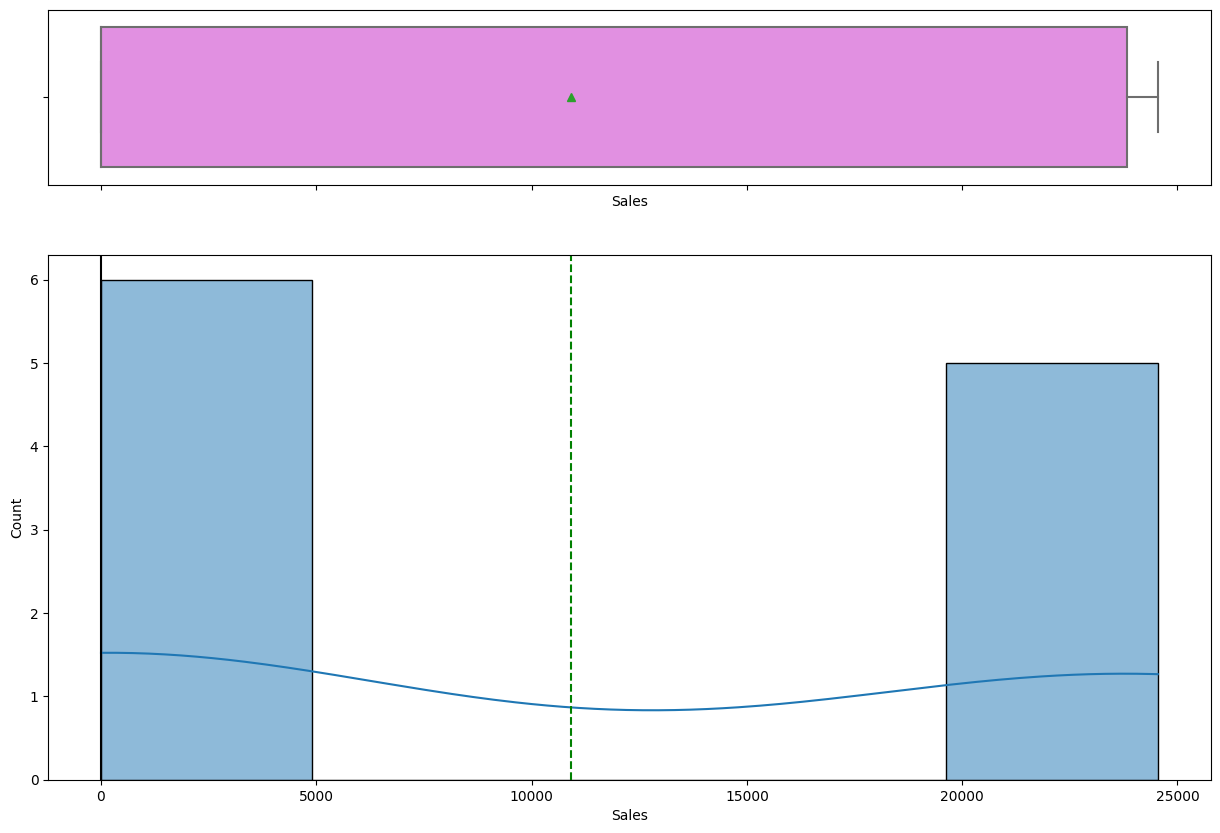

In [133]:
histplot_boxplot(df1['Sales'])

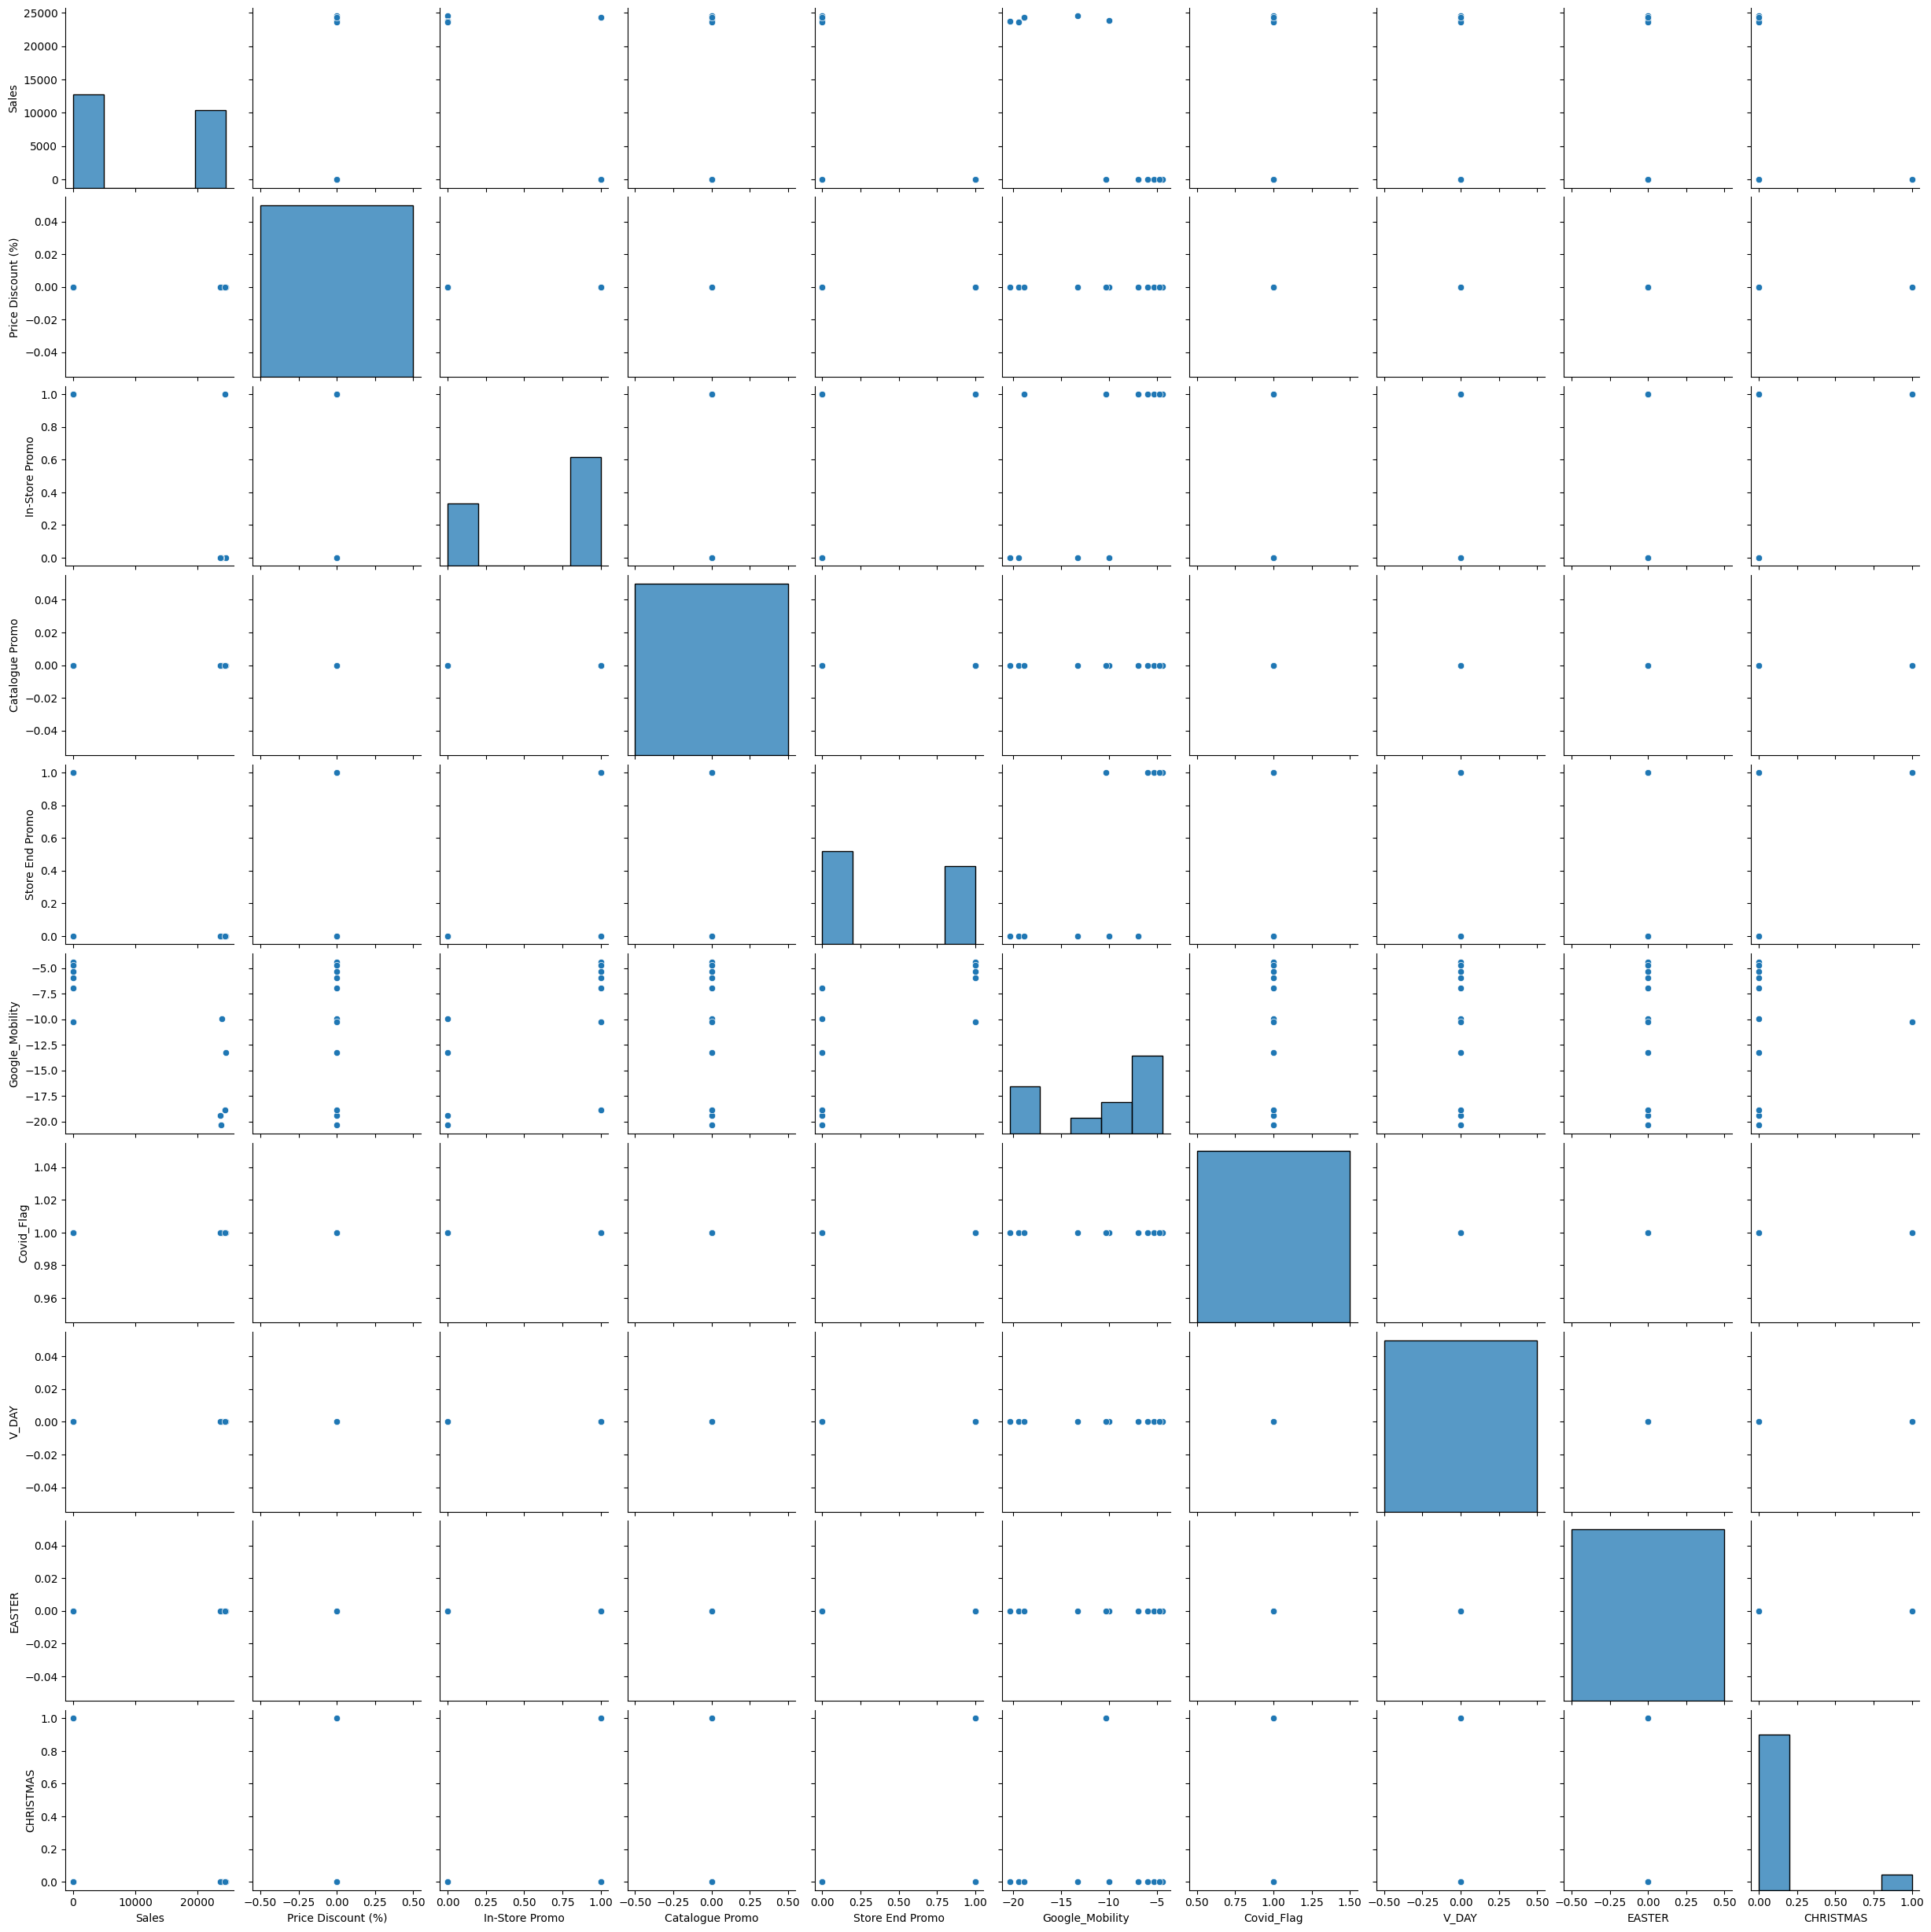

In [134]:

sns.pairplot(data=df1.iloc[:, 1:])

In [135]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     df1test = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",df1test[0])
     print("2. P-Value : ", df1test[1])
     print("3. Num Of Lags : ", df1test[2])
     print("4. Num Of Observations Used For ADF Regression:",      df1test[3])
     print("5. Critical Values :")
     for key, val in df1test[4].items():
         print("\t",key, ": ", val)
adf_test(df1['Sales'])

1. ADF :  -1.0076188092748983
2. P-Value :  0.7504753824440884
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 10
5. Critical Values :
	 1% :  -4.331573
	 5% :  -3.23295
	 10% :  -2.7487


In [136]:
df1["Sales"].astype(int)

181    23891
183    24543
184    23744
185    23606
186    24346
198        0
199        0
200        0
201        0
202        0
203        0
Name: Sales, dtype: int64

In [137]:
df1.head()

,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
181,2020-07-26,23891,0,0,0,0,-9.93,1,0,0,0
183,2020-08-09,24543,0,0,0,0,-13.23,1,0,0,0
184,2020-08-16,23744,0,0,0,0,-20.35,1,0,0,0
185,2020-08-23,23606,0,0,0,0,-19.41,1,0,0,0
186,2020-08-30,24346,0,1,0,0,-18.83,1,0,0,0


In [138]:
df1['Sales'] = pd.to_numeric(df1['Sales'])
df1.dtypes

date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [139]:
el_df=df1.set_index('date')

KeyboardInterrupt: ignored

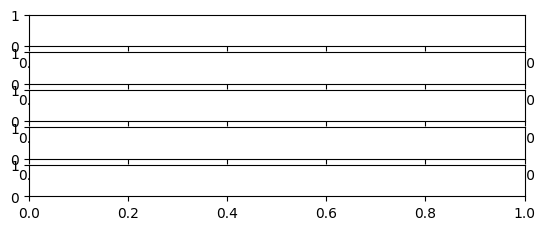

In [140]:
el_df.plot(subplots=True)

In [ ]:
el_df.resample('M').mean()

In [ ]:
print ("\nMissing values :  ", df1.isnull().any())

In [ ]:
el_df.resample('M').mean().plot(subplots=True)

In [ ]:
final_df=el_df.resample('M').mean()

In [ ]:
final_df.isnull().any()

In [ ]:
final_df1=final_df.dropna()

In [ ]:
final_df1.isna().sum()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols_to_scale = ['Google_Mobility']

df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])

In [ ]:
histplot_boxplot(df1['Google_Mobility'])

In [ ]:
import pmdarima as pm
model = pm.auto_arima(final_df1['Sales'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

In [ ]:
pip install pmdarima

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train['Sales'], trace=True,
suppress_warnings=True)

In [ ]:
train=df1.iloc[:-30]
test=df1.iloc[-30:]
train.head()


In [ ]:

test.head()

In [ ]:
train['Sales'] = pd.to_numeric(train['Sales'])
train.dtypes

In [ ]:
import statsmodels.api as sm


In [ ]:
np.asarray(train)

In [ ]:
test['Sales'] = pd.to_numeric(test['Sales'])

In [ ]:
#from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.arima.ARIMA(train['Sales'],order=(2,0,0))
model=model.fit()
model.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Sales'].plot(legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Sales'].mean()
rmse=sqrt(mean_squared_error(pred,test['Sales']))
print(rmse)


In [ ]:
?ARIMA

In [ ]:
window_spec = Window.orderBy("date")
df = df.withColumn("prev_flag", F.lag("Covid_Flag").over(window_spec))

start_dates = df.filter((F.col("Covid_Flag") == 1) & (F.col("prev_flag") == 0))

start_dates.select("Date").show()

**Observation**  
Covid Flag started from February 09, 2020.  

In [ ]:
pandas_df.head()

In [ ]:
! pip install plotly

In [ ]:
import plotly.express as px

pandas_df = df.toPandas()

fig = px.line(pandas_df, x='date', y='Google_Mobility', title='Google_Mobility')

fig.show()

**Observation**  
-Google Mobility is realted Covid19. This is because the line is flat until February 2, 2020 above the plot. The flat line means there are no activities and no exisiting record.   
-After February 9, 2020, it started fluctuating and keep changing. According to the variable Covid Flag, it started recorded as 1 after February 9, 2020. The timing between Google Mobility and Covid Flag is exactly coinside.  
-Google Mobility data tracks travel patterns in detail, such as how often people go to public places and how much time they spend commuting or shopping. This will allow us to assess the risk of spread of infection and predict the spread of infection in a particular region or city.  

In [ ]:
pandas_df = df.select('date', 'Google_Mobility').toPandas()

plt.figure()
plt.plot(pandas_df['date'], pandas_df['Google_Mobility'])
plt.xlabel('date')
plt.ylabel('Google_Mobility')
plt.title('Google_Mobility')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()